# Comparing Pangenome pipeline predictions - Shaw2021 - 50 e. coli genomes

### Import Statements

In [18]:
import numpy as np
import pandas as pd
import vcf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats

%matplotlib inline

#### Pandas Viewing Settings

In [19]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [20]:

def read_PanarooSummaryStats(input_Panaroo_SummaryStats_TXT):
    
    i_Panaroo_Stats_DF = pd.read_csv(input_Panaroo_SummaryStats_TXT, sep = "\t", header=None)
    i_Panaroo_Stats_DF.columns = ["Category", "Range", "GeneCount"]

    Acc_GenesCount = i_Panaroo_Stats_DF["GeneCount"].values[-1] - i_Panaroo_Stats_DF["GeneCount"].values[0]

    i_Panaroo_AccGenesRow = ["Accessory genes","(0% <= strains < 99%)", Acc_GenesCount]

    i_Panaroo_Stats_DF.loc[len(i_Panaroo_Stats_DF.index)] = i_Panaroo_AccGenesRow

    #listOfCat_ToKeep = ["Core genes", "Accessory Genes", "Total genes"]

    i_Panaroo_Stats_DF = i_Panaroo_Stats_DF[ i_Panaroo_Stats_DF["Category"].isin(listOfCat_ToKeep)]   

    # https://www.statology.org/pandas-add-row-to-dataframe/#:~:text=You%20can%20use%20the%20df,loc%5Blen(df. 

    return i_Panaroo_Stats_DF

In [21]:
def read_Ppanggolin_ContextStats(i_Ppanggolin_Default_Content_TXT):
    with open(i_Ppanggolin_Default_Content_TXT, "r") as f:

        #NumCoreGenes = -1
        #NumShellGenes = -1
        #NumCloudGenes = -1
        for line in f:
            line_split = line.split(": ")

            Key = line_split[0].split(" (")[0]
            Value = line_split[-1].strip()

            if Key == "Persistent": NumCoreGenes = int(Value)
            elif Key == "Shell": NumShellGenes = int(Value)
            elif Key == "Cloud": NumCloudGenes = int(Value)

        NumAccessoryGenes = NumShellGenes + NumCloudGenes
        NumTotalGenes = NumCoreGenes + NumAccessoryGenes

    listOf_PG_Rows = []
    listOf_PG_Rows.append( ("Total genes", "(0% <= strains <= 100%)", NumTotalGenes) )
    listOf_PG_Rows.append( ("Accessory genes", "(0% <= strains < 99%)", NumAccessoryGenes) )
    listOf_PG_Rows.append( ("Core genes", "(99% <= strains <= 100%)", NumCoreGenes) )

    PPanggolin_Summary_DF = pd.DataFrame(listOf_PG_Rows)
    PPanggolin_Summary_DF.columns = ["Category", "Range", "GeneCount"]
    
    return PPanggolin_Summary_DF

## Define paths to sample metadata files & key directories

In [22]:

Proj_MainDir = "/n/data1/hms/dbmi/farhat/mm774/Projects"

Ecoli_PG_MainDir = f"{Proj_MainDir}/230905_Ecoli_PG_Analysis"  

Data_MainDir = f"{Ecoli_PG_MainDir}/Data"  

#RefSeq_20Asm_Dir = f"{Data_MainDir}/NCBI.RefSeq.20.EcoliGenomes.dataset/data"

Shaw2021_50Asm_Dir = f"{Data_MainDir}/Shaw2021.50Genomes.Data/data"

Shaw2021_Meta_TSV = f"{Data_MainDir}/Shaw2021.SelectedIsolates.50I.tsv"  

input_FA_PATH_TSVs_Dir = f"{Ecoli_PG_MainDir}/input_PATH_SMK_TSVs"

Shaw2021_Ecoli_50Asm_Meta_TSV = f"{input_FA_PATH_TSVs_Dir}/231011.Shaw2021.Ecoli.50I.MetaData.tsv"


## Parse in metadata DFs

In [23]:
Shaw_50A_Info_DF = pd.read_csv(Shaw2021_Ecoli_50Asm_Meta_TSV, sep = "\t")
Shaw_50A_Info_DF.shape

(50, 24)

### Define list of SampleIDs

In [24]:
Shaw_50A_Info_DF.head(1)  

,Isolate,Biosample Accession,Short Reads Accession,Long Reads Accession,Assembly Accession,Animal or WwTW,Isolate source information,Timepoint,Niche,Niche.2,Location,Genus,Species,ST assignment,Circularised plasmids,Number of contigs,Circularised chromosome (1=yes),Total genome size (bp),Chromosome GC (if known),Phylogroup (E. coli only),Alternative isolate name,Long read sequencing method,SampleID,Genome_ASM_PATH
0,RH02|T1-C02,SAMN15147960,SRR11948863,SRR12299015,GCA_014109125.1,Animal,Pooled pig faecal samples collected from floor...,1,Pig,Faeces,RH02,Escherichia,Escherichia coli,10.0,1,2,1,4953790,50.7,A,RHB02-C02,PacBio,GCA_014109125,/n/data1/hms/dbmi/farhat/mm774/Projects/230905...


In [25]:
E50I_SampleIDs = Shaw_50A_Info_DF["SampleID"].values   
len(E50I_SampleIDs)

50

# Define output dir of the Mtb-WGA-SMK processing pipeline

In [26]:
# Define varaint calling pipeline output directories

WGA_SMK_Outputs_Dir = f"{Ecoli_PG_MainDir}/SMK_OutDirs"

#PG_Ecoli_20I_OutDir = WGA_SMK_Outputs_Dir + "/230905_Ecoli_2OI_V1"
PG_Ecoli_50I_OutDir = WGA_SMK_Outputs_Dir + "/231011_Ecoli_Shaw2021_5OI_V1"


In [27]:
!ls -alh $PG_Ecoli_50I_OutDir

total 1.9M
drwxrwsr-x 59 mm774 farhat 1.8K Jan  1 18:03 .
drwxrwsr-x  4 mm774 farhat   83 Oct 11 23:17 ..
drwxrwsr-x 53 mm774 farhat 1.6K Oct 12 01:52 AsmAnalysis
drwxrwsr-x  4 mm774 farhat   63 Oct 12 02:14 FastANI
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:11 GCA_013602835
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:11 GCA_013712565
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:11 GCA_013713325
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:11 GCA_013728735
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:11 GCA_013732895
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:09 GCA_013745515
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:11 GCA_013746655
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:11 GCA_013750375
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:09 GCA_013752075
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:11 GCA_013752295
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:09 GCA_013782445
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:13 GCA_013783465
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:11 GCA_013786125
drwxrwsr-x  3 mm7

## Define output dirs of pipeline

In [28]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
                         'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',  'Roary_Default', ]# 'Ppanggolin_Default',] #'Ppanggolin_I95', 'Ppanggolin_I90' ]

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',  'Roary_Default', ]# 'Ppanggolin_Default',] #'Ppanggolin_I95', 'Ppanggolin_I90' ]


target_OutputDir = PG_Ecoli_50I_OutDir

i_Pangenome_Dir = f"{target_OutputDir}/PanGenome_Analysis"

listOfCat_ToKeep = ["Core genes", "Accessory genes", "Total genes"]


dictOf_PG_OutInfo = {}
dictOf_PG_PresAbs_DF = {}
dictOf_PG_OutDir_PATHs = {}

for i_SampleSet in ["All"]: #"HighBUSCOIsolates"]:
    
    dictOf_PG_OutInfo[i_SampleSet] = {}
    dictOf_PG_OutDir_PATHs[i_SampleSet] = {}
    dictOf_PG_PresAbs_DF[i_SampleSet] = {}
    
    for AnnoPipeline in ["Bakta",]: #"PGAP"]:
        
        dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline] = {}
        dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline] = {}
        dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline] = {}
        
        for AsmTech in ["LongRead", "ShortRead"]:       
            
            dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech] = {}
            dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech] = {}
            dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline][AsmTech] = {}
            
            
            for i_PipeNameWiParam in tqdm(PipeName_WiParam_List):
                
                dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = {}
                
                #if (AsmTech == "ShortRead") & (AnnoPipeline == "PGAP"): continue 
                if (i_SampleSet == "HighBUSCOIsolates") & (AnnoPipeline == "PGAP"): continue 
                
                if i_SampleSet == "All": DataSetSuffix = "_AllIsolates"  
                elif i_SampleSet == "HighBUSCOIsolates": DataSetSuffix = "_HighBUSCOIsolates"

                if AsmTech == "LongRead": SeqTechPrefix = ""
                elif AsmTech == "ShortRead": SeqTechPrefix = "SR_"

                if AnnoPipeline == "Bakta": AnnoSuffix = ""
                elif AnnoPipeline == "PGAP": AnnoSuffix = "_WiPGAPAnno_V1"


                i_Pipeline_OutDir = f"{i_Pangenome_Dir}/"+SeqTechPrefix+i_PipeNameWiParam+DataSetSuffix+AnnoSuffix

                if "Panaroo" in i_PipeNameWiParam:
                    i_PG_Summary_Txt = f"{i_Pipeline_OutDir}/summary_statistics.txt"

                    i_PG_Stats_DF = read_PanarooSummaryStats(i_PG_Summary_Txt)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    
                    i_Gene_PresAbs_CSV_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.csv"    
                    i_Pangenome_Ref_FA_PATH = f"{i_Pipeline_OutDir}/pan_genome_reference.fa"
                    
                    #i_Gene_PresAbs_DF = parse_Panaroo_GenePresAbs_CSV(i_Gene_PresAbs_CSV_PATH)  

                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_CSV"] = i_Gene_PresAbs_CSV_PATH
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Pangenome_Ref_FA"] = i_Pangenome_Ref_FA_PATH


                elif "Roary" in i_PipeNameWiParam:
                    i_PG_Summary_Txt = f"{i_Pipeline_OutDir}/summary_statistics.txt"

                    i_PG_Stats_DF = read_PanarooSummaryStats(i_PG_Summary_Txt)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   

                    i_Gene_PresAbs_CSV_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.csv"    

                    i_Pangenome_Ref_FA_PATH = f"{i_Pipeline_OutDir}/pan_genome_reference.fa"

                    
                    #i_Gene_PresAbs_DF = parse_Panaroo_GenePresAbs_CSV(i_Gene_PresAbs_CSV_PATH)  
                    
                    
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_CSV"] = i_Gene_PresAbs_CSV_PATH
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Pangenome_Ref_FA"] = i_Pangenome_Ref_FA_PATH

                    
                elif "Ppanggolin" in i_PipeNameWiParam:
                    print(i_PipeNameWiParam)
                    i_PG_Summary_Txt = f"{i_Pipeline_OutDir}/pangenome.ContentSummary.txt"
                    #print(i_PG_Summary_Txt)
                    #!grep 'Families' $i_PG_Summary_Txt 
                    i_PG_Stats_DF = read_Ppanggolin_ContextStats(i_PG_Summary_Txt, False)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    print(i_PG_Stats_DF)
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   

                    i_Gene_PresAbs_Rtab_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.Rtab"    
                    
                    #i_Gene_PresAbs_DF = parse_Panaroo_GenePresAbs_Rtab(i_Gene_PresAbs_Rtab_PATH)
                                          
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_Rtab"] = i_Gene_PresAbs_Rtab_PATH


                dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = i_PG_Stats_DF
                
                #dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = i_Gene_PresAbs_DF
                
                dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Stats_TXT"] = i_PG_Summary_Txt


100%|██████████| 7/7 [00:00<00:00, 123.24it/s]


In [29]:
#!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/230905_Ecoli_PG_Analysis/SMK_OutDirs/231011_Ecoli_Shaw2021_5OI_V1/PanGenome_Analysis/

In [30]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Panaroo_Strict_MergeParalogs"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet
0,Core genes,(99% <= strains <= 100%),3035,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All
4,Total genes,(0% <= strains <= 100%),14410,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All
5,Accessory genes,(0% <= strains < 99%),11375,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All


In [42]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Panaroo_Strict_MergeParalogs"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet
0,Core genes,(99% <= strains <= 100%),3035,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All
4,Total genes,(0% <= strains <= 100%),14410,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All
5,Accessory genes,(0% <= strains < 99%),11375,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All


In [43]:
dictOf_PG_OutInfo["All"]["Bakta"]["ShortRead"]["Panaroo_Strict_MergeParalogs"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet
0,Core genes,(99% <= strains <= 100%),2834,Bakta,Panaroo_Strict_MergeParalogs,ShortRead,All
4,Total genes,(0% <= strains <= 100%),12836,Bakta,Panaroo_Strict_MergeParalogs,ShortRead,All
5,Accessory genes,(0% <= strains < 99%),10002,Bakta,Panaroo_Strict_MergeParalogs,ShortRead,All


# 1) Merge all Pan-genome counts accross all combinations evaluated

In [46]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs',  'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',  'Roary_Default',] #'Ppanggolin_I95', 'Ppanggolin_I90' ]


listOf_PG_InfoDFs = []
for i_SampleSet in ["All"]: # "HighBUSCOIsolates"
    for AnnoPipeline in ["Bakta"]:
        for AsmTech in ["LongRead", "ShortRead"]:
            for i_PipeNameWiParam in PipeName_WiParam_List:
                i_PG_Stats_DF = dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]
                
                listOf_PG_InfoDFs.append(i_PG_Stats_DF)


PG_Merged_Stats_LRandSR_DF = pd.concat(listOf_PG_InfoDFs)

PG_Merged_Stats_LRandSR_DF["MethodAndTech"] = PG_Merged_Stats_LRandSR_DF["Method"] + "_" +PG_Merged_Stats_LRandSR_DF["SeqType"]

PG_Merged_Stats_LRandSR_DF["MethodAndTechAndAnno"] = PG_Merged_Stats_LRandSR_DF["Method"] + "_" +PG_Merged_Stats_LRandSR_DF["SeqType"]  + "_" +PG_Merged_Stats_LRandSR_DF["Annotation"]  

PG_Merged_Stats_LRandSR_DF.shape


(42, 9)

In [47]:
PG_Merged_Stats_LRandSR_DF.head(4)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno
0,Core genes,(99% <= strains <= 100%),3035,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta
4,Total genes,(0% <= strains <= 100%),14410,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta
5,Accessory genes,(0% <= strains < 99%),11375,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta
0,Core genes,(99% <= strains <= 100%),3036,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta


In [48]:
PG_Merged_Stats_LRandSR_DF["Range"].value_counts()

(99% <= strains <= 100%)    14
(0% <= strains <= 100%)     14
(0% <= strains < 99%)       14
Name: Range, dtype: int64

In [49]:
PG_Merged_Stats_LRandSR_DF[ PG_Merged_Stats_LRandSR_DF["Method"].str.contains("Ppanggolin") ].query("Category == 'Accessory genes' ") 

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno


In [50]:
PG_Merged_Stats_LRandSR_DF.shape

(42, 9)

## Divide Pan-genome summary stats by "assembly type" and "gene category"

In [51]:
PG_Merged_Stats_LRandSR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ")
PG_Merged_Stats_LRandSR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ")
PG_Merged_Stats_LRandSR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ")

In [52]:
PG_Merged_Stats_LR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ").query(" SeqType == 'LongRead'  ")

In [53]:
PG_Merged_Stats_SR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ").query(" SeqType == 'ShortRead'  ")
PG_Merged_Stats_SR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ").query(" SeqType == 'ShortRead'  ")
PG_Merged_Stats_SR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ").query(" SeqType == 'ShortRead'  ")

In [54]:
PG_Merged_Stats_LRandSR_Acc_Bakta_DF = PG_Merged_Stats_LRandSR_Acc_DF.query("Annotation == 'Bakta'")

# 2) Create Pan-genome summary table - Wide version 

This table will have pangenome predictions (Total, Core, and Accessory genes) across all methods + technologies.

### Pivot table to get summary per Method and Seqtype

In [55]:
PG_Merged_Stats_LRandSR_DF.head(2)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno
0,Core genes,(99% <= strains <= 100%),3035,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta
4,Total genes,(0% <= strains <= 100%),14410,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta


In [56]:
PG_WideSumm_DF = pd.pivot(PG_Merged_Stats_LRandSR_DF,
                          index = ["MethodAndTechAndAnno"],
                          columns = ["Category"],
                          values = ["GeneCount"] )    

PG_WideSumm_DF.columns = PG_WideSumm_DF.columns.droplevel(0)
PG_WideSumm_DF.columns.name = None
PG_WideSumm_DF = PG_WideSumm_DF.reset_index()


In [57]:
PG_WideSumm_DF.shape

(14, 4)

In [58]:
PG_WideSumm_DF.head()

,MethodAndTechAndAnno,Accessory genes,Core genes,Total genes
0,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,11605,3036,14641
1,Panaroo_Moderate_MergeParalogs_ShortRead_Bakta,10628,2834,13462
2,Panaroo_Sensitive_MergeParalogs_LongRead_Bakta,11996,3036,15032
3,Panaroo_Sensitive_MergeParalogs_ShortRead_Bakta,12690,2834,15524
4,Panaroo_Strict_MergeParalogs_LongRead_Bakta,11375,3035,14410


In [59]:
PG_WideSumm_DF[ PG_WideSumm_DF["MethodAndTechAndAnno"].str.contains("Ppanggolin") ]  

,MethodAndTechAndAnno,Accessory genes,Core genes,Total genes


In [60]:
PG_Merged_Stats_LRandSR_DF[ PG_Merged_Stats_LRandSR_DF["Method"].str.contains("Ppanggolin") ].query("Category == 'Accessory genes' ") 

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno


In [61]:
PG_WideSumm_DF = pd.pivot(PG_Merged_Stats_LRandSR_DF,
                          index = ["MethodAndTechAndAnno"],
                          columns = ["Category"],
                          values = ["GeneCount"] )    

PG_WideSumm_DF.columns = PG_WideSumm_DF.columns.droplevel(0)
PG_WideSumm_DF.columns.name = None
PG_WideSumm_DF = PG_WideSumm_DF.reset_index()


PG_WideSumm_DF["SeqType"] = PG_WideSumm_DF["MethodAndTechAndAnno"].str.split("_").str[-2]
PG_WideSumm_DF["Anno"] = PG_WideSumm_DF["MethodAndTechAndAnno"].str.split("_").str[-1]
PG_WideSumm_DF["Method"] = PG_WideSumm_DF["MethodAndTechAndAnno"].str.replace("_LongRead", "").str.replace("_ShortRead", "").str.replace("_Bakta", "").str.replace("_PGAP", "")       
PG_WideSumm_DF["PangenomeTool"] = PG_WideSumm_DF["MethodAndTechAndAnno"].str.split("_").str[0:1].str[0]

# Do some reformatting 
NewColOrder = ['PangenomeTool', 'SeqType', 'Anno', 'Method', 'Total genes',  'Core genes', 'Accessory genes',  ]

PG_WideSumm_DF = PG_WideSumm_DF[NewColOrder]

PG_WideSumm_DF = PG_WideSumm_DF.sort_values(["SeqType", "PangenomeTool", "Accessory genes"]).reset_index(drop=True)

In [62]:
PG_WideSumm_DF.columns

Index(['PangenomeTool', 'SeqType', 'Anno', 'Method', 'Total genes', 'Core genes', 'Accessory genes'], dtype='object')

In [63]:
#PG_WideSumm_DF

In [64]:
PG_WideSumm_DF.query("SeqType == 'LongRead'")

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes
0,Panaroo,LongRead,Bakta,Panaroo_Strict_MergeParalogs,14410,3035,11375
1,Panaroo,LongRead,Bakta,Panaroo_Moderate_MergeParalogs,14641,3036,11605
2,Panaroo,LongRead,Bakta,Panaroo_Sensitive_MergeParalogs,15032,3036,11996
3,Roary,LongRead,Bakta,Roary_NoSplitParalogs_I80,13312,3035,10277
4,Roary,LongRead,Bakta,Roary_NoSplitParalogs_I90,14851,2915,11936
5,Roary,LongRead,Bakta,Roary_NoSplitParalogs,17783,2484,15299
6,Roary,LongRead,Bakta,Roary_Default,21400,2394,19006


In [65]:
PG_WideSumm_DF.query("SeqType == 'ShortRead'")

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes
7,Panaroo,ShortRead,Bakta,Panaroo_Strict_MergeParalogs,12836,2834,10002
8,Panaroo,ShortRead,Bakta,Panaroo_Moderate_MergeParalogs,13462,2834,10628
9,Panaroo,ShortRead,Bakta,Panaroo_Sensitive_MergeParalogs,15524,2834,12690
10,Roary,ShortRead,Bakta,Roary_NoSplitParalogs_I80,13420,2825,10595
11,Roary,ShortRead,Bakta,Roary_NoSplitParalogs_I90,14933,2711,12222
12,Roary,ShortRead,Bakta,Roary_NoSplitParalogs,17825,2314,15511
13,Roary,ShortRead,Bakta,Roary_Default,19721,2234,17487


In [66]:
PG_WideSumm_DF.head(5)

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes
0,Panaroo,LongRead,Bakta,Panaroo_Strict_MergeParalogs,14410,3035,11375
1,Panaroo,LongRead,Bakta,Panaroo_Moderate_MergeParalogs,14641,3036,11605
2,Panaroo,LongRead,Bakta,Panaroo_Sensitive_MergeParalogs,15032,3036,11996
3,Roary,LongRead,Bakta,Roary_NoSplitParalogs_I80,13312,3035,10277
4,Roary,LongRead,Bakta,Roary_NoSplitParalogs_I90,14851,2915,11936


# Plotting key figures (For SR vs LR - Bakta + 3 pipelines)

# Table 1) Pan-genome predictions - LR vs SR - 3 pipelines

In [67]:
PG_WideSumm_DF.head(1)

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes
0,Panaroo,LongRead,Bakta,Panaroo_Strict_MergeParalogs,14410,3035,11375


In [68]:
#print(PG_WideSumm_DF.to_latex())

In [69]:
PG_WideSumm_DF = PG_WideSumm_DF.sort_values(["Method", "SeqType"])

In [70]:
PG_WideSumm_DF

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes
1,Panaroo,LongRead,Bakta,Panaroo_Moderate_MergeParalogs,14641,3036,11605
8,Panaroo,ShortRead,Bakta,Panaroo_Moderate_MergeParalogs,13462,2834,10628
2,Panaroo,LongRead,Bakta,Panaroo_Sensitive_MergeParalogs,15032,3036,11996
9,Panaroo,ShortRead,Bakta,Panaroo_Sensitive_MergeParalogs,15524,2834,12690
0,Panaroo,LongRead,Bakta,Panaroo_Strict_MergeParalogs,14410,3035,11375
7,Panaroo,ShortRead,Bakta,Panaroo_Strict_MergeParalogs,12836,2834,10002
6,Roary,LongRead,Bakta,Roary_Default,21400,2394,19006
13,Roary,ShortRead,Bakta,Roary_Default,19721,2234,17487
5,Roary,LongRead,Bakta,Roary_NoSplitParalogs,17783,2484,15299
12,Roary,ShortRead,Bakta,Roary_NoSplitParalogs,17825,2314,15511


In [71]:
676 - 436

240

In [72]:
813 - 469

344

In [73]:
PG_WideSumm_DF["Weight"] = PG_WideSumm_DF.groupby("Method")["Accessory genes"].transform('sum') / 2

In [74]:
#PG_WideSumm_DF

In [75]:

orderToPlot_X = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
                         'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',  'Roary_Default', 'Ppanggolin_Default',] #'Ppanggolin_I95', 'Ppanggolin_I90' ]

dictOfValues_To_Label = {'Panaroo_Strict_MergeParalogs': 'Panaroo (Strict & MergeParalogs)',
                         'Panaroo_Moderate_MergeParalogs': 'Panaroo (Moderate & MergeParalogs)',
                         'Panaroo_Sensitive_MergeParalogs': 'Panaroo (Sensitive & MergeParalogs)',
                         'Panaroo_Strict': 'Panaroo (Strict)',
                         'Panaroo_Moderate': 'Panaroo (Moderate)',
                         'Panaroo_Sensitive': 'Panaroo (Sensitive)',
                         'Roary_NoSplitParalogs_I80': 'Roary (MergeParalogs & I80)',
                         'Roary_NoSplitParalogs_I90': 'Roary (MergeParalogs & I90)',
                         'Roary_NoSplitParalogs': 'Roary (MergeParalogs)',
                         'Roary_Default': 'Roary (Default)',
                         'Ppanggolin_Default': 'Ppanggolin (Default)',
                         'Ppanggolin_I90': 'Ppanggolin (I90)',
                         'Ppanggolin_I95': 'Ppanggolin (I95)',}


PG_WideSumm_DF = PG_WideSumm_DF.sort_values("Method", key=lambda x: pd.Categorical(x, categories=orderToPlot_X, ordered=True))
#PG_WideSumm_DF = PG_WideSumm_DF.sort_values(["Method", "SeqType"], key=lambda x: pd.Categorical(x, categories=orderToPlot_X, ordered=True))

PG_WideSumm_V2_DF = PG_WideSumm_DF.copy()

PG_WideSumm_V2_DF["Method"] = PG_WideSumm_V2_DF["Method"].replace(dictOfValues_To_Label)

NewColOrder = ['PangenomeTool', 'SeqType', 'Anno', 'Method', 'Total genes',  'Core genes', 'Accessory genes',  ]

PG_WideSumm_V2_DF_Trim = PG_WideSumm_V2_DF[NewColOrder].reset_index(drop=True)

PG_WideSumm_V2_DF_Trim

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes
0,Panaroo,LongRead,Bakta,Panaroo (Strict & MergeParalogs),14410,3035,11375
1,Panaroo,ShortRead,Bakta,Panaroo (Strict & MergeParalogs),12836,2834,10002
2,Panaroo,LongRead,Bakta,Panaroo (Moderate & MergeParalogs),14641,3036,11605
3,Panaroo,ShortRead,Bakta,Panaroo (Moderate & MergeParalogs),13462,2834,10628
4,Panaroo,LongRead,Bakta,Panaroo (Sensitive & MergeParalogs),15032,3036,11996
5,Panaroo,ShortRead,Bakta,Panaroo (Sensitive & MergeParalogs),15524,2834,12690
6,Roary,LongRead,Bakta,Roary (MergeParalogs & I80),13312,3035,10277
7,Roary,ShortRead,Bakta,Roary (MergeParalogs & I80),13420,2825,10595
8,Roary,LongRead,Bakta,Roary (MergeParalogs & I90),14851,2915,11936
9,Roary,ShortRead,Bakta,Roary (MergeParalogs & I90),14933,2711,12222


In [76]:
# https://stackoverflow.com/questions/35634238/how-to-save-a-pandas-dataframe-table-as-a-png   

In [77]:
#from pandas.table.plotting import table # EDIT: see deprecation warnings below
#from pandas.plotting import table 
#ax = plt.subplot(111, frame_on=False) # no visible frame
#ax.xaxis.set_visible(False)  # hide the x axis
#ax.yaxis.set_visible(False)  # hide the y axis

#table(ax, PG_WideSumm_V2_DF_Trim)  # where df is your data frame


In [78]:
PG_WideSumm_V2_DF[ PG_WideSumm_V2_DF["Method"].str.contains("Ppanggolin") ]  

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes,Weight


In [79]:
PG_WideSumm_V2_DF.columns  

Index(['PangenomeTool', 'SeqType', 'Anno', 'Method', 'Total genes', 'Core genes', 'Accessory genes', 'Weight'], dtype='object')

In [80]:
dictOfValues_To_Label.keys()

dict_keys(['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs', 'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict', 'Panaroo_Moderate', 'Panaroo_Sensitive', 'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90', 'Roary_NoSplitParalogs', 'Roary_Default', 'Ppanggolin_Default', 'Ppanggolin_I90', 'Ppanggolin_I95'])

In [81]:
dictOfValues_To_Label.values()

dict_values(['Panaroo (Strict & MergeParalogs)', 'Panaroo (Moderate & MergeParalogs)', 'Panaroo (Sensitive & MergeParalogs)', 'Panaroo (Strict)', 'Panaroo (Moderate)', 'Panaroo (Sensitive)', 'Roary (MergeParalogs & I80)', 'Roary (MergeParalogs & I90)', 'Roary (MergeParalogs)', 'Roary (Default)', 'Ppanggolin (Default)', 'Ppanggolin (I90)', 'Ppanggolin (I95)'])

In [82]:

MethodValues_X = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                 'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
                 'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
                 'Roary_NoSplitParalogs',  'Roary_Default', 'Ppanggolin_Default' ] #'Ppanggolin_I90', 'Ppanggolin_I95',]

Plot_TickLabels = ['Panaroo (Strict & MergeParalogs)', 'Panaroo (Moderate & MergeParalogs)',
                 'Panaroo (Sensitive & MergeParalogs)', 'Panaroo (Strict)',
                 'Panaroo (Moderate)', 'Panaroo (Sensitive)',  'Roary (MergeParalogs & I80)', 'Roary (MergeParalogs & I90)',
                 'Roary (MergeParalogs)', 'Roary (Default)', 'Ppanggolin (Default)' ] #'Ppanggolin (I90)', 'Ppanggolin (I95)']


dictOfValues_To_Label = {}  

for i in range(len(MethodValues_X)):
        
    dictOfValues_To_Label[MethodValues_X[i]]   =   Plot_TickLabels[i]
    

In [83]:
dictOfValues_To_Label

{'Panaroo_Strict_MergeParalogs': 'Panaroo (Strict & MergeParalogs)',
 'Panaroo_Moderate_MergeParalogs': 'Panaroo (Moderate & MergeParalogs)',
 'Panaroo_Sensitive_MergeParalogs': 'Panaroo (Sensitive & MergeParalogs)',
 'Panaroo_Strict': 'Panaroo (Strict)',
 'Panaroo_Moderate': 'Panaroo (Moderate)',
 'Panaroo_Sensitive': 'Panaroo (Sensitive)',
 'Roary_NoSplitParalogs_I80': 'Roary (MergeParalogs & I80)',
 'Roary_NoSplitParalogs_I90': 'Roary (MergeParalogs & I90)',
 'Roary_NoSplitParalogs': 'Roary (MergeParalogs)',
 'Roary_Default': 'Roary (Default)',
 'Ppanggolin_Default': 'Ppanggolin (Default)'}

In [84]:
dictOfValues_To_Label = {'Panaroo_Strict_MergeParalogs': 'Panaroo (Strict & MergeParalogs)',
 'Panaroo_Moderate_MergeParalogs': 'Panaroo (Moderate & MergeParalogs)',
 'Panaroo_Sensitive_MergeParalogs': 'Panaroo (Sensitive & MergeParalogs)',
 'Panaroo_Strict': 'Panaroo (Strict)',
 'Panaroo_Moderate': 'Panaroo (Moderate)',
 'Panaroo_Sensitive': 'Panaroo (Sensitive)',
 'Roary_NoSplitParalogs_I80': 'Roary (MergeParalogs & I80)',
 'Roary_NoSplitParalogs_I90': 'Roary (MergeParalogs & I90)',
 'Roary_NoSplitParalogs': 'Roary (MergeParalogs)',
 'Roary_Default': 'Roary (Default)',
 'Ppanggolin_Default': 'Ppanggolin (Default)',
 'Ppanggolin_I90': 'Ppanggolin (I90)',
 'Ppanggolin_I95': 'Ppanggolin (I95)'}


In [85]:
PG_WideSumm_DF.groupby("SeqType")["Total genes"].describe()

,count,mean,std,min,25%,50%,75%,max
SeqType,,,,,,,,
LongRead,7.0,15918.428571,2773.387271,13312.0,14525.5,14851.0,16407.5,21400.0
ShortRead,7.0,15388.714286,2550.639770,12836.0,13441.0,14933.0,16674.5,19721.0


In [86]:
PG_WideSumm_DF.groupby(["SeqType", "Anno"])["Total genes"].describe()  

,,count,mean,std,min,25%,50%,75%,max
SeqType,Anno,,,,,,,,
LongRead,Bakta,7.0,15918.428571,2773.387271,13312.0,14525.5,14851.0,16407.5,21400.0
ShortRead,Bakta,7.0,15388.714286,2550.639770,12836.0,13441.0,14933.0,16674.5,19721.0


In [87]:
PG_WideSumm_DF.groupby(["SeqType", "Anno"])["Accessory genes"].describe()  

,,count,mean,std,min,25%,50%,75%,max
SeqType,Anno,,,,,,,,
LongRead,Bakta,7.0,13070.571429,3040.396512,10277.0,11490.0,11936.0,13647.5,19006.0
ShortRead,Bakta,7.0,12733.571429,2800.035646,10002.0,10611.5,12222.0,14100.5,17487.0


In [88]:
PG_WideSumm_DF.groupby(["SeqType", "Anno"])["Core genes"].describe()  

,,count,mean,std,min,25%,50%,75%,max
SeqType,Anno,,,,,,,,
LongRead,Bakta,7.0,2847.857143,283.938625,2394.0,2699.5,3035.0,3035.5,3036.0
ShortRead,Bakta,7.0,2655.142857,265.104023,2234.0,2512.5,2825.0,2834.0,2834.0


In [89]:
PG_WideSumm_DF.head(4)

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes,Weight
0,Panaroo,LongRead,Bakta,Panaroo_Strict_MergeParalogs,14410,3035,11375,10688.5
7,Panaroo,ShortRead,Bakta,Panaroo_Strict_MergeParalogs,12836,2834,10002,10688.5
1,Panaroo,LongRead,Bakta,Panaroo_Moderate_MergeParalogs,14641,3036,11605,11116.5
8,Panaroo,ShortRead,Bakta,Panaroo_Moderate_MergeParalogs,13462,2834,10628,11116.5


In [90]:
!mkdir Results3_Plots/

In [91]:
PG_WideSumm_DF.to_csv("Results3_Plots/Ecoli.PG.LRvsSR.BaktaAnno.tsv", sep="\t", index= False)  

In [92]:
PG_Merged_Stats_LRandSR_DF.to_csv("Results3_Plots/Ecoli.PG.LRvsSR.BaktaAnno.MergedStats.tsv", sep="\t", index= False)  

In [93]:
PG_Merged_Stats_LRandSR_DF.columns   

Index(['Category', 'Range', 'GeneCount', 'Annotation', 'Method', 'SeqType', 'DataSet', 'MethodAndTech', 'MethodAndTechAndAnno'], dtype='object')

In [94]:
PG_Merged_Stats_LRandSR_DF.head(2)  

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno
0,Core genes,(99% <= strains <= 100%),3035,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta
4,Total genes,(0% <= strains <= 100%),14410,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta


In [95]:
PG_WideSumm_DF.head(5)

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes,Weight
0,Panaroo,LongRead,Bakta,Panaroo_Strict_MergeParalogs,14410,3035,11375,10688.5
7,Panaroo,ShortRead,Bakta,Panaroo_Strict_MergeParalogs,12836,2834,10002,10688.5
1,Panaroo,LongRead,Bakta,Panaroo_Moderate_MergeParalogs,14641,3036,11605,11116.5
8,Panaroo,ShortRead,Bakta,Panaroo_Moderate_MergeParalogs,13462,2834,10628,11116.5
2,Panaroo,LongRead,Bakta,Panaroo_Sensitive_MergeParalogs,15032,3036,11996,12343.0


## Figure 2) Accessory genome predictions - Hybrid vs SR - Bakta + 3 pipelines

In [96]:
PG_Merged_Stats_LRandSR_Acc_DF.head(1)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno
5,Accessory genes,(0% <= strains < 99%),11375,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta


In [97]:
PG_Merged_Stats_LRandSR_Acc_DF["Method"].value_counts()

Panaroo_Strict_MergeParalogs       2
Panaroo_Moderate_MergeParalogs     2
Panaroo_Sensitive_MergeParalogs    2
Roary_NoSplitParalogs_I80          2
Roary_NoSplitParalogs_I90          2
Roary_NoSplitParalogs              2
Roary_Default                      2
Name: Method, dtype: int64

In [98]:
PG_Merged_Stats_LRandSR_Acc_Bakta_DF.head(4)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno
5,Accessory genes,(0% <= strains < 99%),11375,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta
5,Accessory genes,(0% <= strains < 99%),11605,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta
5,Accessory genes,(0% <= strains < 99%),11996,Bakta,Panaroo_Sensitive_MergeParalogs,LongRead,All,Panaroo_Sensitive_MergeParalogs_LongRead,Panaroo_Sensitive_MergeParalogs_LongRead_Bakta
5,Accessory genes,(0% <= strains < 99%),10277,Bakta,Roary_NoSplitParalogs_I80,LongRead,All,Roary_NoSplitParalogs_I80_LongRead,Roary_NoSplitParalogs_I80_LongRead_Bakta


In [99]:
PG_Merged_Stats_LRandSR_Acc_Bakta_DF[ PG_Merged_Stats_LRandSR_Acc_Bakta_DF["Method"].str.contains("Ppanggolin") ]  

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno


In [101]:
import matplotlib.patches as mpatches


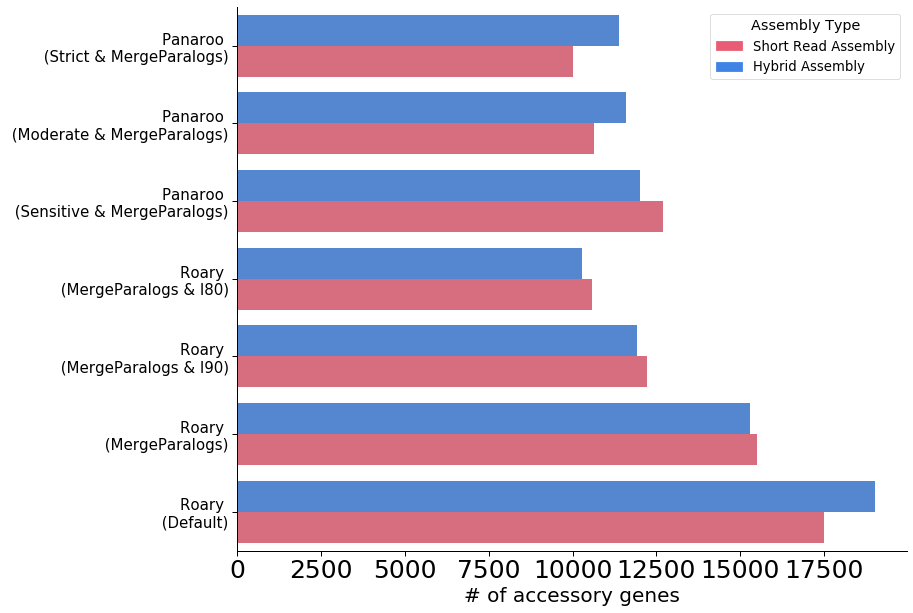

In [104]:
fig, axs = plt.subplots(1, 1, figsize= (12, 10), sharex=True)

#sns.set_context("poster")
sns.set_context("paper", font_scale=1.5)

orderToPlot_X = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                 'Panaroo_Sensitive_MergeParalogs', 'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
                 'Roary_NoSplitParalogs',  'Roary_Default', ] # 'Ppanggolin_I95', 'Ppanggolin_I90']


sns.barplot(y = "Method", x = "GeneCount", hue = "SeqType", data = PG_Merged_Stats_LRandSR_Acc_Bakta_DF, order = orderToPlot_X, ax = axs, palette = ["#3F84E5", "#E85D75"] )
#plt.ylim(0, 5000)
# 
#axs.set_ylabel("Pangenome Analysis Pipeline")
axs.set_ylabel("")

axs.set_xlabel("# of accessory genes", fontsize = 20)


Plot_TickLabels = ['Panaroo \n (Strict & MergeParalogs)', 'Panaroo \n (Moderate & MergeParalogs)',
                 'Panaroo \n (Sensitive & MergeParalogs)', 'Roary \n (MergeParalogs & I80)', 'Roary \n (MergeParalogs & I90)',
                 'Roary \n (MergeParalogs)',  'Roary \n (Default)', ]#'Ppanggolin \n (Default)',] # 'Ppanggolin \n (I95)', 'Ppanggolin \n (I90)',]

axs.set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})

#axs.set_xticklabels(labels = Plot_TickLabels, rotation=45, fontdict = {"fontsize": 12})

SR_patch = mpatches.Patch(color = "#E85D75", label='Short Read Assembly')
Hybrid_patch = mpatches.Patch(color="#3F84E5", label='Hybrid Assembly')

#axs.legend(title = "Assembly Type", labels = ["Hybrid Assembly", "Short Read Assembly"], color = ["#3F84E5", "#E85D75"] )
plt.legend(title = "Assembly Type", handles=[SR_patch, Hybrid_patch])

#axs.set_title("Accessory genome size predictions")
#axs.set_title("Accessory gene counts: Hybrid vs SR assemblies")
sns.despine()
plt.xticks(fontsize=25)
#plt.savefig("Plots/4.PG.AccGeneCounts.SRvsLR.WiBakta.Barplot.png", dpi = 300, bbox_inches="tight")
#plt.savefig("Plots/4.PG.AccGeneCounts.SRvsLR.WiBakta.Barplot.svg", bbox_inches="tight")

#plt.xticks(labels = Plot_TickLabels, rotation=45)
plt.show()

In [105]:
PG_WideSumm_V2_DF.head(2)

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes,Weight
0,Panaroo,LongRead,Bakta,Panaroo (Strict & MergeParalogs),14410,3035,11375,10688.5
7,Panaroo,ShortRead,Bakta,Panaroo (Strict & MergeParalogs),12836,2834,10002,10688.5


In [107]:
PG_Merged_Stats_LRandSR_Pangenome_DF.head(1)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno
4,Total genes,(0% <= strains <= 100%),14410,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta


In [108]:
PG_Merged_Stats_LRandSR_Acc_DF.head(3)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno
5,Accessory genes,(0% <= strains < 99%),11375,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta
5,Accessory genes,(0% <= strains < 99%),11605,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta
5,Accessory genes,(0% <= strains < 99%),11996,Bakta,Panaroo_Sensitive_MergeParalogs,LongRead,All,Panaroo_Sensitive_MergeParalogs_LongRead,Panaroo_Sensitive_MergeParalogs_LongRead_Bakta


# Let's try a 4-way comparison of SeqType & Anno Method

In [109]:
dictOf_PG_OutInfo.keys()

dict_keys(['All'])

In [110]:
dictOf_PG_OutInfo["All"].keys() 

dict_keys(['Bakta'])

# 1) Merge all Pan-genome counts accross all combinations evaluated

In [114]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                 'Panaroo_Sensitive_MergeParalogs', 'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
                 'Roary_NoSplitParalogs',  'Roary_Default', ] # 'Ppanggolin_I95', 'Ppanggolin_I90']


listOf_PG_InfoDFs = []
for i_SampleSet in ["All"]: # "HighBUSCOIsolates"
    for AnnoPipeline in ["Bakta", ]:
        for AsmTech in ["LongRead", "ShortRead"]:
            for i_PipeNameWiParam in PipeName_WiParam_List:

                #if (AsmTech == "ShortRead") and (AnnoPipeline == "PGAP"): continue
                    #print("Remove - ", AnnoPipeline, AsmTech, i_PipeNameWiParam)
                
                #print(AnnoPipeline, AsmTech, i_PipeNameWiParam)
                
                i_PG_Stats_DF = dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]
                
                listOf_PG_InfoDFs.append(i_PG_Stats_DF)

PG_Merged_Stats_SeqAndAnnoType_DF = pd.concat(listOf_PG_InfoDFs)

PG_Merged_Stats_SeqAndAnnoType_DF["MethodAndTech"] = PG_Merged_Stats_SeqAndAnnoType_DF["Method"] + "_" +PG_Merged_Stats_SeqAndAnnoType_DF["SeqType"]
PG_Merged_Stats_SeqAndAnnoType_DF["AnnoAndTech"] = PG_Merged_Stats_SeqAndAnnoType_DF["Annotation"] + "-" +PG_Merged_Stats_SeqAndAnnoType_DF["SeqType"]

PG_Merged_Stats_SeqAndAnnoType_DF["PangenomeTool"] = PG_Merged_Stats_SeqAndAnnoType_DF["Method"].str.split("_").str[0]

PG_Merged_Stats_SeqAndAnnoType_DF.shape


(42, 10)

In [115]:
PG_Merged_Stats_SeqAndAnnoType_DF.head(2)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,AnnoAndTech,PangenomeTool
0,Core genes,(99% <= strains <= 100%),3035,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Bakta-LongRead,Panaroo
4,Total genes,(0% <= strains <= 100%),14410,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Bakta-LongRead,Panaroo


In [116]:
PG_Merged_Stats_SeqAndAnnoType_DF["Category"].unique()

array(['Core genes', 'Total genes', 'Accessory genes'], dtype=object)

In [117]:
PG_Merged_Stats_SeqAndAnnoType_Total_DF = PG_Merged_Stats_SeqAndAnnoType_DF.query("Category == 'Total genes' ")  
PG_Merged_Stats_SeqAndAnnoType_Total_DF.shape

(14, 10)

In [118]:
PG_Merged_Stats_SeqAndAnnoType_Core_DF = PG_Merged_Stats_SeqAndAnnoType_DF.query("Category == 'Core genes' ")
PG_Merged_Stats_SeqAndAnnoType_Core_DF.shape

(14, 10)

In [119]:
PG_Merged_Stats_SeqAndAnnoType_Acc_DF = PG_Merged_Stats_SeqAndAnnoType_DF.query("Category == 'Accessory genes' ")
PG_Merged_Stats_SeqAndAnnoType_Acc_DF.shape  

(14, 10)

In [120]:
PG_Merged_Stats_SeqAndAnnoType_Acc_DF["AnnoAndTech"].value_counts()

Bakta-LongRead     7
Bakta-ShortRead    7
Name: AnnoAndTech, dtype: int64

In [121]:
!mkdir Results3_Plots/

mkdir: cannot create directory ‘Results3_Plots/’: File exists


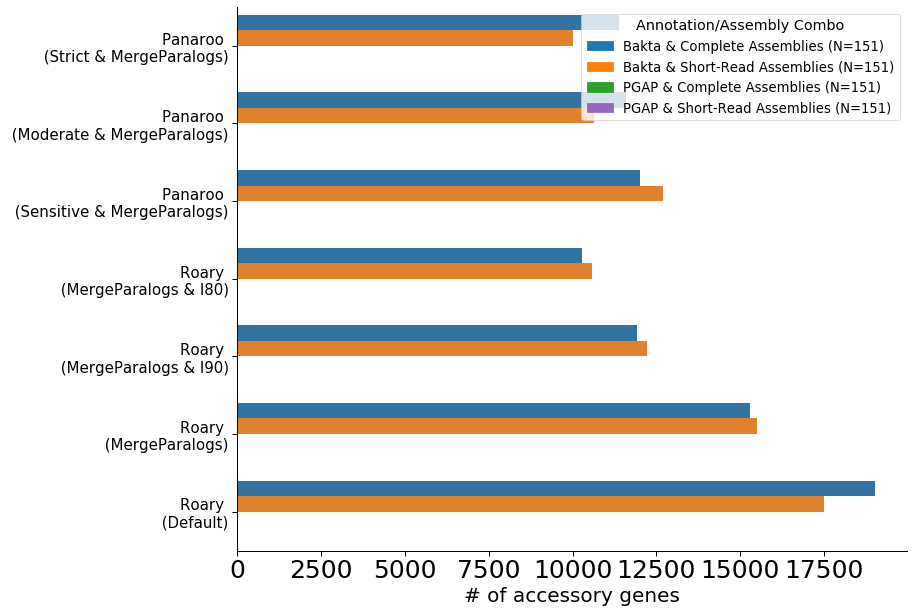

In [123]:
fig, axs = plt.subplots(1, 1, figsize= (12, 10), sharex=True)

#sns.set_context("poster")
sns.set_context("paper", font_scale=1.5)

orderToPlot_X = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                 'Panaroo_Sensitive_MergeParalogs',  'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
                 'Roary_NoSplitParalogs',  'Roary_Default', ] # 'Ppanggolin_I95', 'Ppanggolin_I90']

Plot_TickLabels = ['Panaroo \n (Strict & MergeParalogs)', 'Panaroo \n (Moderate & MergeParalogs)',
                 'Panaroo \n (Sensitive & MergeParalogs)', 'Roary \n (MergeParalogs & I80)', 'Roary \n (MergeParalogs & I90)',
                 'Roary \n (MergeParalogs)',  'Roary \n (Default)',] # 'Ppanggolin \n (I95)', 'Ppanggolin \n (I90)',]


AnnoAndTech_hue_Color_Dict = { "Bakta-LongRead": "#1f77b4",
                    "Bakta-ShortRead": "#ff7f0e",
                    "PGAP-LongRead": "#2ca02c",
                    "PGAP-ShortRead": "#9467bd" }


hue_orderToPlot_X = AnnoAndTech_hue_Color_Dict.keys()
pallete_ForPlot = AnnoAndTech_hue_Color_Dict.values()
sns.barplot(y = "Method", x = "GeneCount", hue = "AnnoAndTech", data = PG_Merged_Stats_SeqAndAnnoType_Acc_DF, order = orderToPlot_X, hue_order = hue_orderToPlot_X, ax = axs, palette = pallete_ForPlot )
#plt.ylim(0, 5000)
# 
#axs.set_ylabel("Pangenome Analysis Pipeline")
axs.set_ylabel("")

axs.set_xlabel("# of accessory genes", fontsize = 20)


axs.set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})

#axs.set_xticklabels(labels = Plot_TickLabels, rotation=45, fontdict = {"fontsize": 12})

Bakta_CompAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["Bakta-LongRead"], label='Bakta & Complete Assemblies (N=151)')
Bakta_SRAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["Bakta-ShortRead"], label='Bakta & Short-Read Assemblies (N=151)')
PGAP_CompAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["PGAP-LongRead"], label='PGAP & Complete Assemblies (N=151)')
PGAP_SRAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["PGAP-ShortRead"], label='PGAP & Short-Read Assemblies (N=151)')

axs.legend(title = "Annotation/Assembly Combo", handles=[Bakta_CompAsm_patch, Bakta_SRAsm_patch, PGAP_CompAsm_patch, PGAP_SRAsm_patch])

#axs.set_title("Accessory genome size predictions")
#axs.set_title("Accessory gene counts: Hybrid vs SR assemblies")
sns.despine()
plt.xticks(fontsize=25)


#plt.savefig("Results3_Plots/3.PG.AccGeneCounts.SRvsLR.AND.BaktaVsPGAP.CombinedBarplot.png", dpi = 300, bbox_inches="tight")
#plt.savefig("Results3_Plots/3.PG.AccGeneCounts.SRvsLR.AND.BaktaVsPGAP.CombinedBarplot.svg", bbox_inches="tight")

#plt.xticks(labels = Plot_TickLabels, rotation=45)
plt.show()

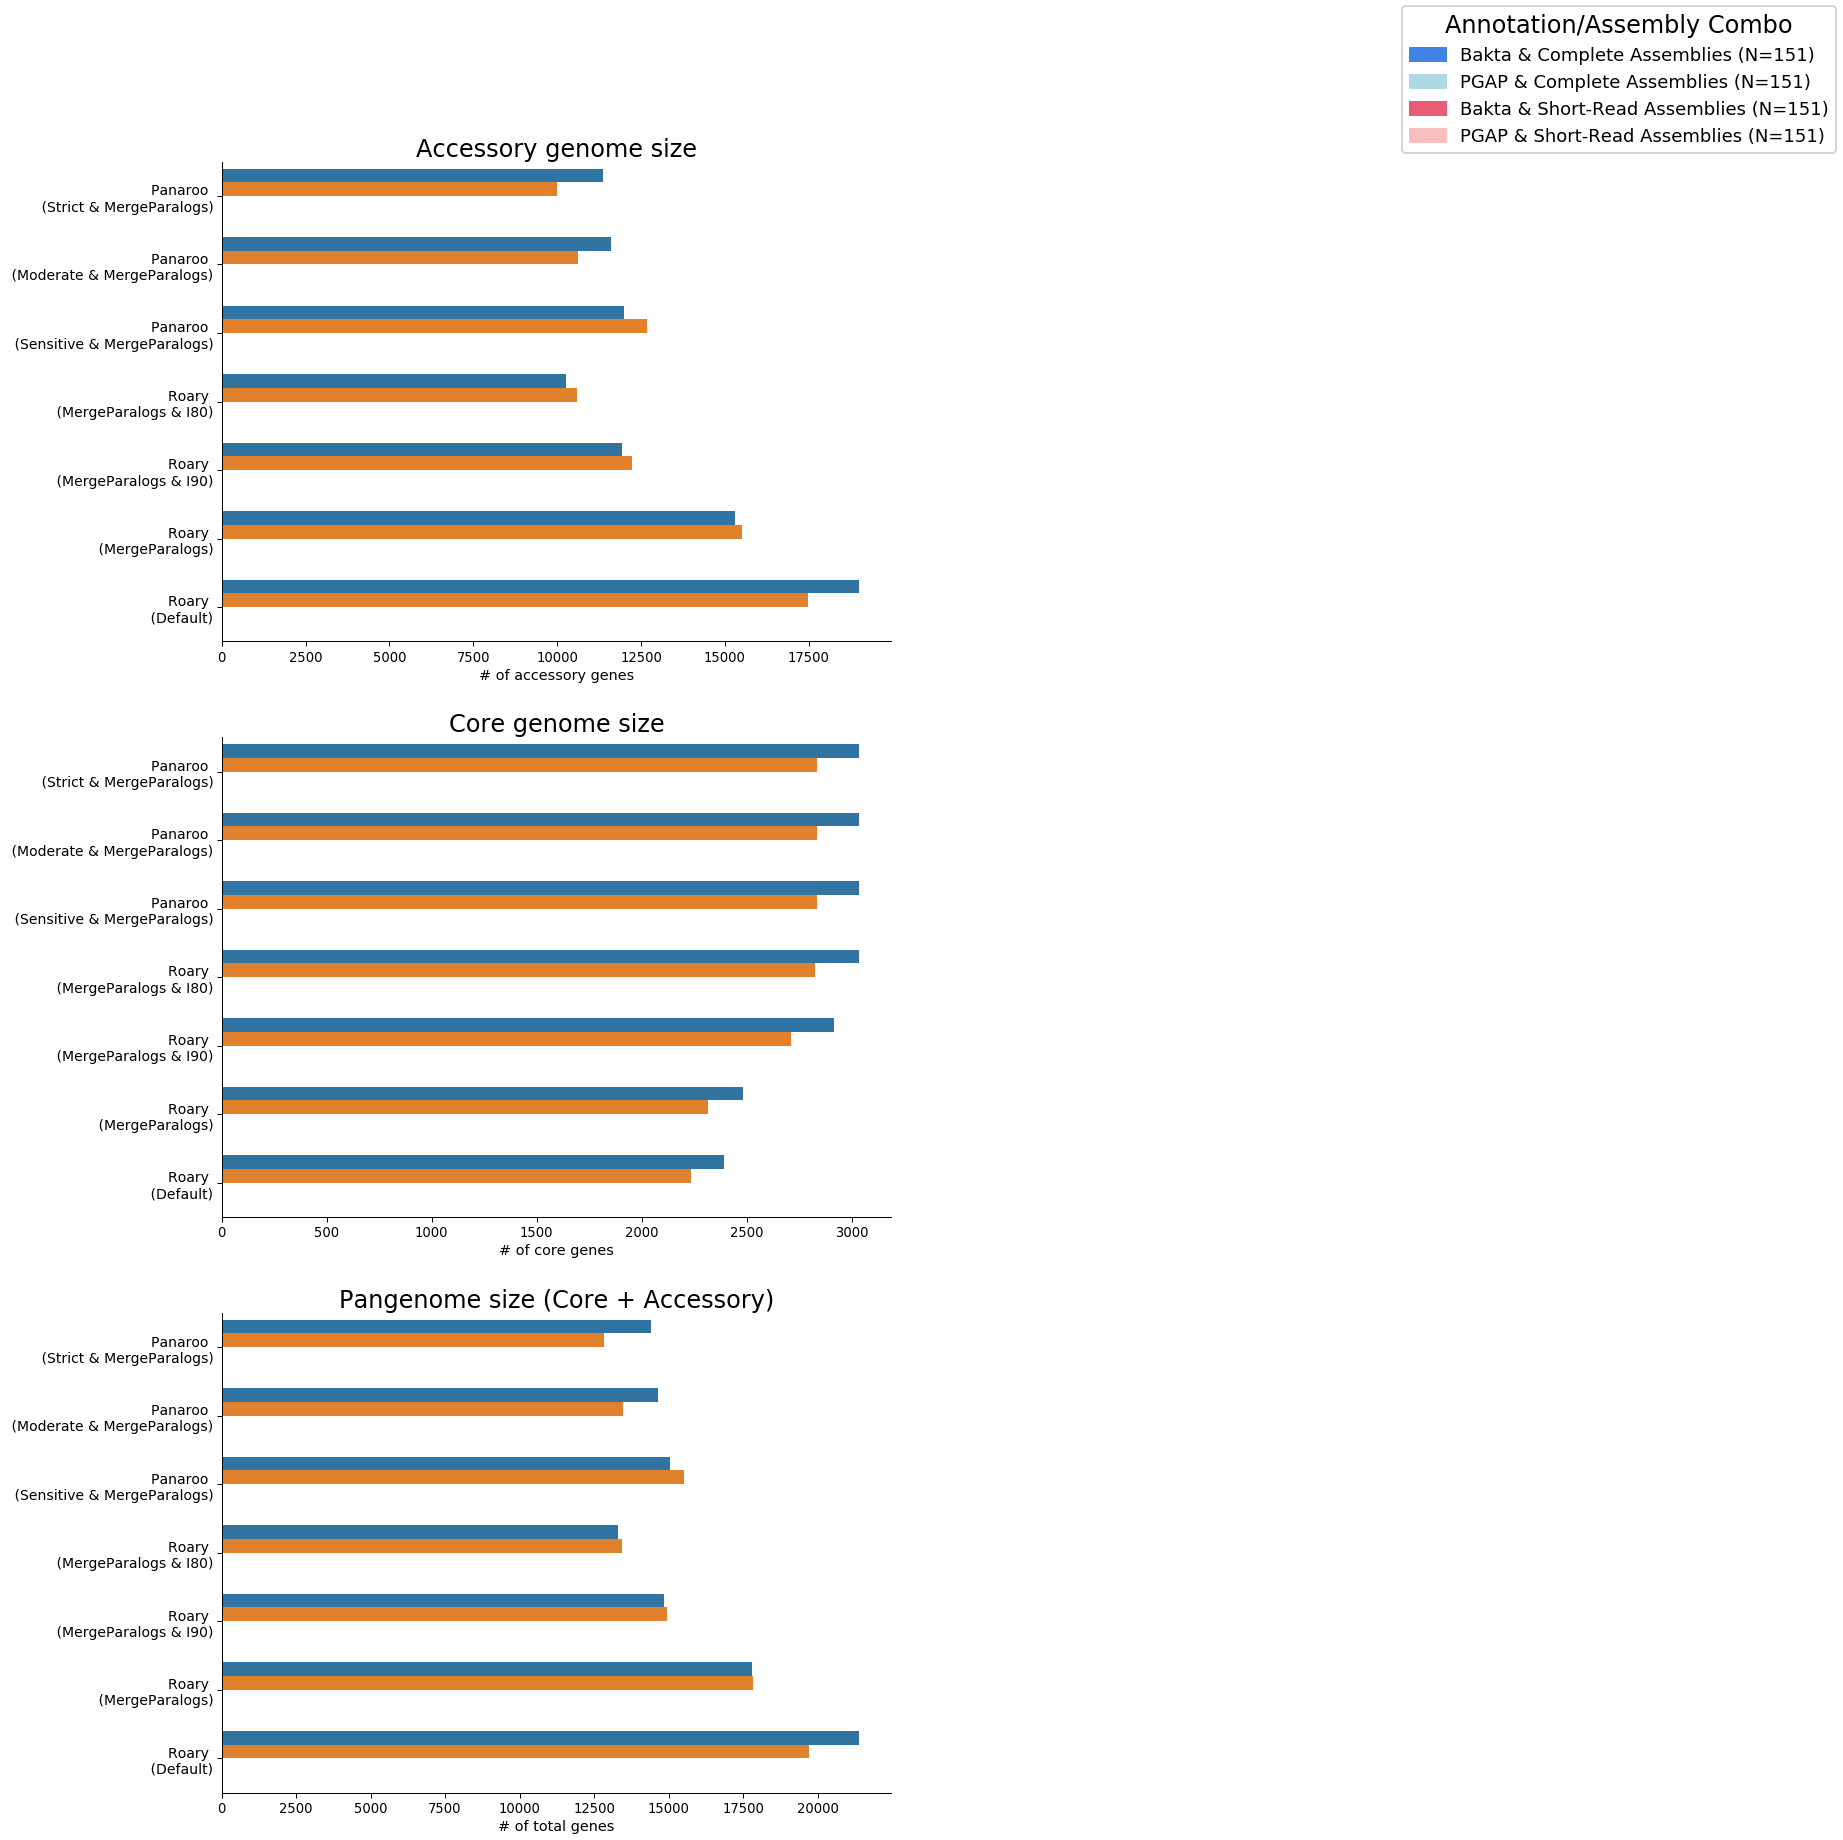

In [124]:
fig, axs = plt.subplots(3, 1, figsize= (12, 30), sharex=False, sharey=True)
sns.set_context("poster")



#sns.barplot(y = "Method", x = "GeneCount", hue = "Annotation", data = PG_Merged_Stats_BaktaVsPGAP_Pangenome_DF, order = orderToPlot_X, ax = axs[0], palette = ["#FF934F", "#A9CBB7"] )

sns.barplot(y = "Method", x = "GeneCount", hue = "AnnoAndTech", data = PG_Merged_Stats_SeqAndAnnoType_Acc_DF, order = orderToPlot_X, hue_order = hue_orderToPlot_X, ax = axs[0], palette = pallete_ForPlot )
sns.barplot(y = "Method", x = "GeneCount", hue = "AnnoAndTech", data = PG_Merged_Stats_SeqAndAnnoType_Core_DF, order = orderToPlot_X, hue_order = hue_orderToPlot_X, ax = axs[1], palette = pallete_ForPlot )
sns.barplot(y = "Method", x = "GeneCount", hue = "AnnoAndTech", data = PG_Merged_Stats_SeqAndAnnoType_Total_DF, order = orderToPlot_X, hue_order = hue_orderToPlot_X, ax = axs[2], palette = pallete_ForPlot )

axs[0].set_ylabel("")
axs[1].set_ylabel(""), axs[2].set_ylabel("")
axs[0].set_xlabel("# of accessory genes", rotation=0,)
axs[1].set_xlabel("# of core genes", rotation=0,)
axs[2].set_xlabel("# of total genes", rotation=0,)


# For all 3 "ax" set x tick labels
for i_ax in axs:
    i_ax.set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 14})

Bakta_CompAsm_patch = mpatches.Patch(color="#3F84E5", label='Bakta & Complete Assemblies (N=151)')
Bakta_SRAsm_patch = mpatches.Patch(color = "#E85D75", label='Bakta & Short-Read Assemblies (N=151)')
PGAP_CompAsm_patch = mpatches.Patch(color="#ADD8E6", label='PGAP & Complete Assemblies (N=151)')
PGAP_SRAsm_patch = mpatches.Patch(color="#f7bfbe", label='PGAP & Short-Read Assemblies (N=151)')

axs[0].legend(title = "Annotation/Assembly Combo", handles=[Bakta_CompAsm_patch, PGAP_CompAsm_patch, Bakta_SRAsm_patch, PGAP_SRAsm_patch],
              bbox_to_anchor=(1.75, 1), fontsize= 18) 

axs[1].get_legend().remove(), axs[2].get_legend().remove()

axs[0].set_title("Accessory genome size")
axs[1].set_title("Core genome size")
axs[2].set_title("Pangenome size (Core + Accessory)")
sns.despine()
#plt.tight_layout()
#plt.xticks(labels = Plot_TickLabels, rotation=45)

#plt.savefig("Results3_Plots/3.PG.Counts.SRvsLR.AND.BaktaVsPGAP.Combined3Barplots.png", dpi = 300, bbox_inches="tight")
#plt.savefig("Results3_Plots/3.PG.Counts.SRvsLR.AND.BaktaVsPGAP.Combined3Barplots.svg", bbox_inches="tight")

plt.show()

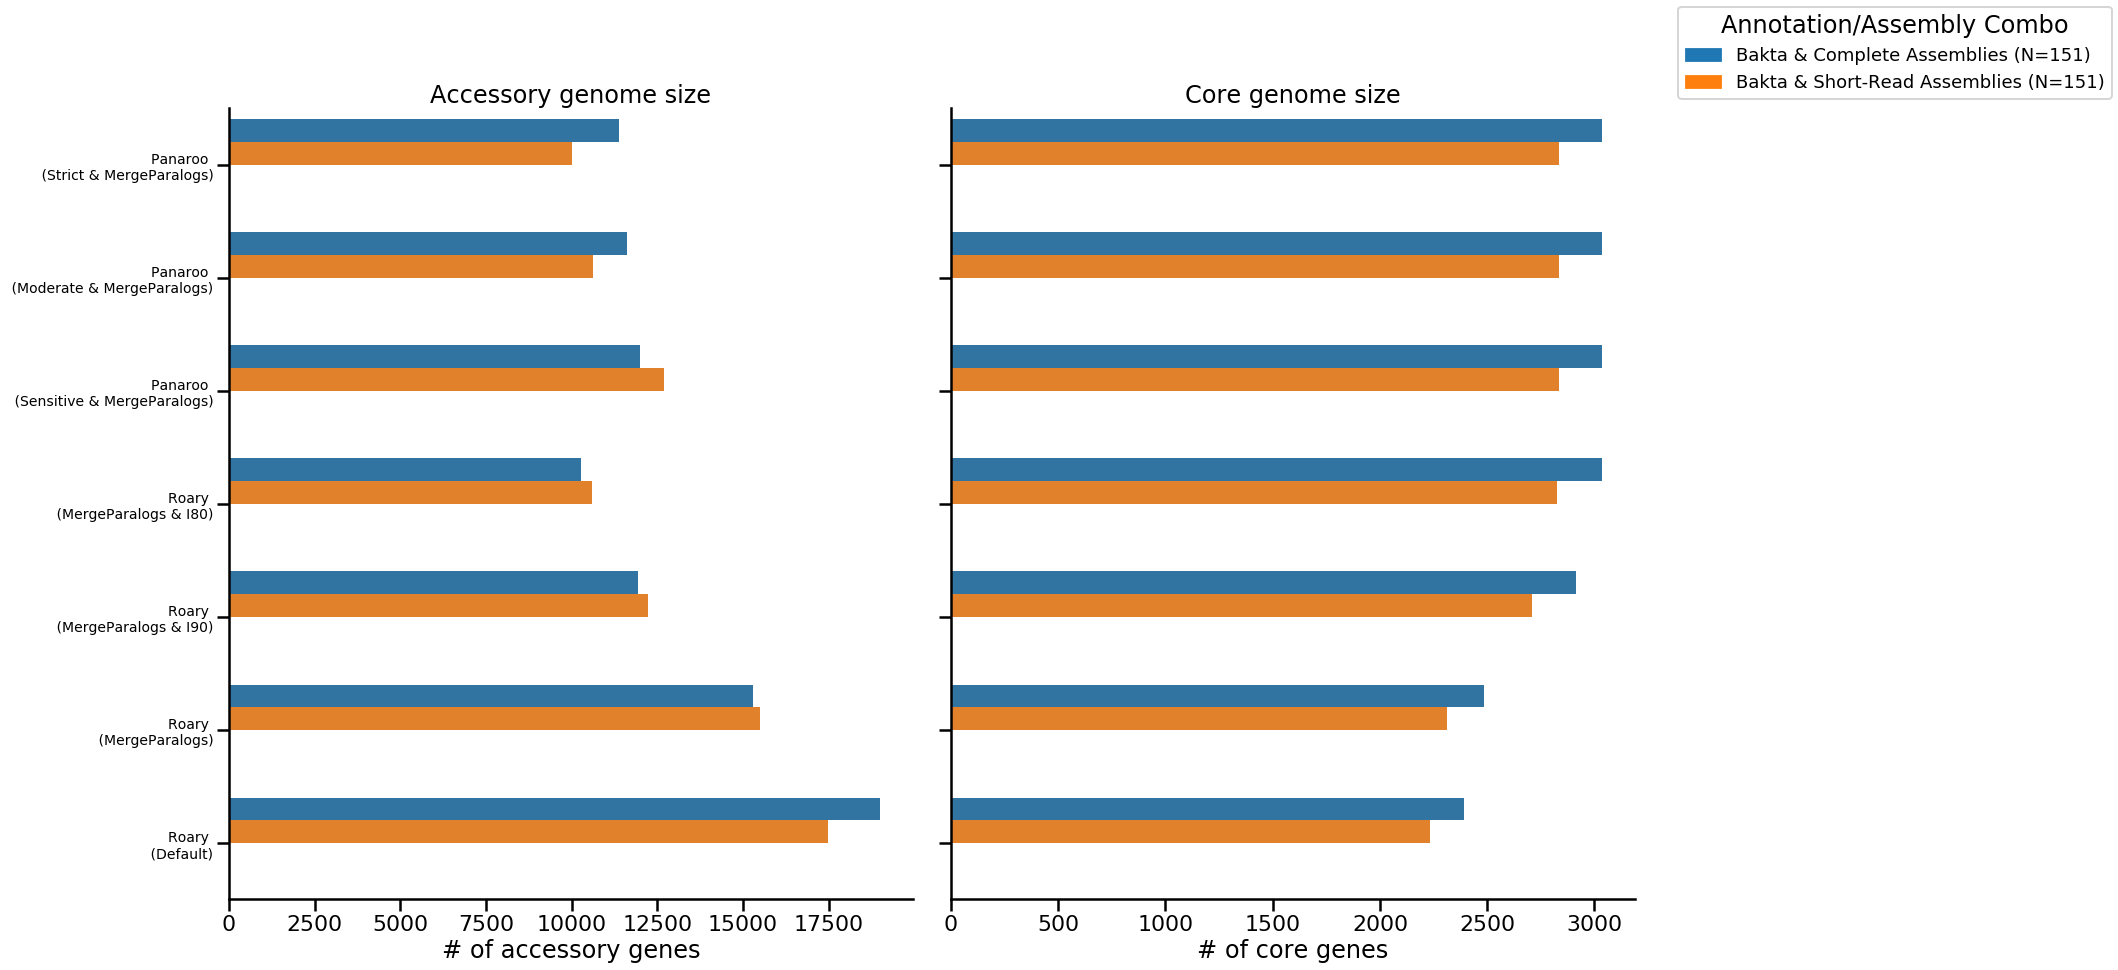

In [130]:
# Change the subplot configuration to 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(30, 14), sharex=False, sharey=True)
sns.set_context("poster")

# Plotting on the first and second subplot
sns.barplot(y="Method", x="GeneCount", hue="AnnoAndTech", data=PG_Merged_Stats_SeqAndAnnoType_Acc_DF, order=orderToPlot_X, hue_order=hue_orderToPlot_X, ax=axs[0], palette=pallete_ForPlot)
sns.barplot(y="Method", x="GeneCount", hue="AnnoAndTech", data=PG_Merged_Stats_SeqAndAnnoType_Core_DF, order=orderToPlot_X, hue_order=hue_orderToPlot_X, ax=axs[1], palette=pallete_ForPlot)

# Set labels
axs[0].set_ylabel("") # Adjust as needed
axs[1].set_ylabel("") # Adjust as needed

axs[0].set_xlabel("# of accessory genes", rotation=0)
axs[1].set_xlabel("# of core genes", rotation=0)

# Set tick labels
for i_ax in axs:
    i_ax.set_yticklabels(labels=Plot_TickLabels, rotation=0, fontdict={"fontsize": 14})

# Adjust legend
axs[1].legend(title="Annotation/Assembly Combo", handles=[Bakta_CompAsm_patch, Bakta_SRAsm_patch], bbox_to_anchor=(1.05, 1), fontsize= 18) 
axs[0].get_legend().remove()

# Set titles
axs[0].set_title("Accessory genome size")
axs[1].set_title("Core genome size")

# Despine and layout adjustment
sns.despine()
plt.tight_layout()

plt.show()

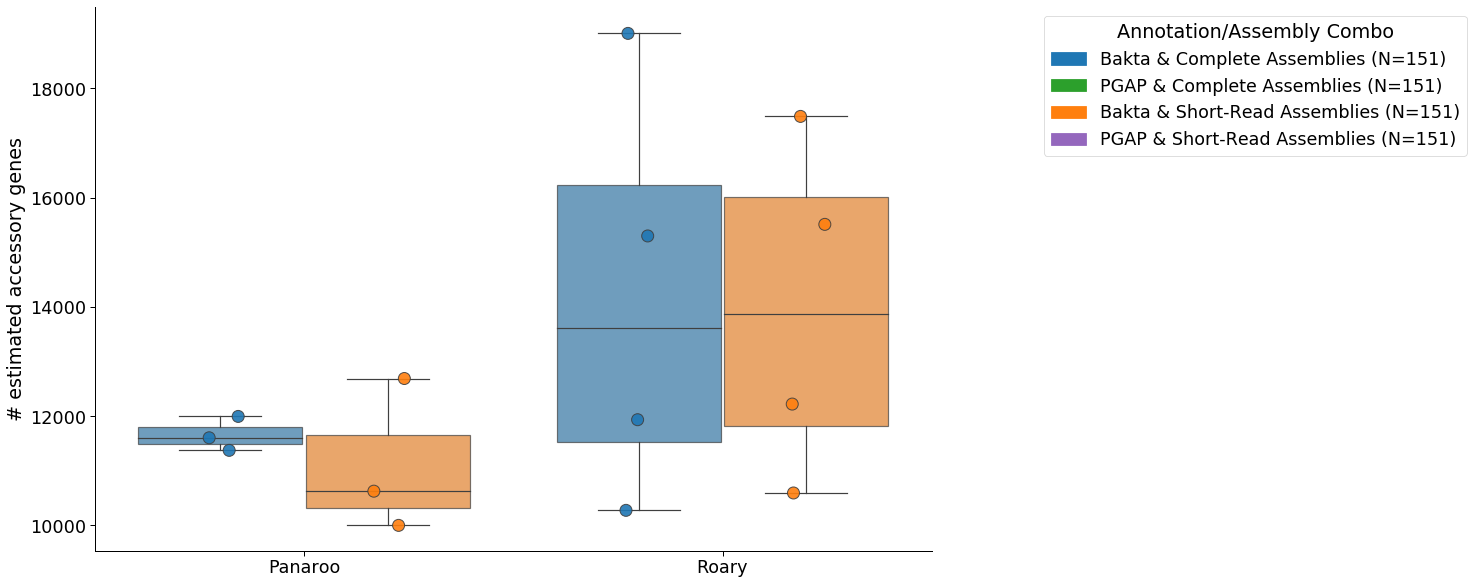

In [127]:
AnnoAndTech_hue_Color_Dict = { "Bakta-LongRead": "#1f77b4",
                    "Bakta-ShortRead": "#ff7f0e",
                    "PGAP-LongRead": "#2ca02c",
                    "PGAP-ShortRead": "#9467bd" }


fig, axs = plt.subplots(1, 1, figsize= (15, 10), sharey = False)
#sns.set_context("poster")
sns.set_context("paper", font_scale=2)


hue_orderToPlot_V2 = ["Bakta-LongRead",  "PGAP-LongRead", "Bakta-ShortRead", "PGAP-ShortRead"]

hue_orderToPlot_V2 = ["Bakta-LongRead", "Bakta-ShortRead" ]


sns.stripplot(y = "GeneCount", x = "PangenomeTool", hue = "AnnoAndTech", data = PG_Merged_Stats_SeqAndAnnoType_Acc_DF, linewidth=1, size = 12, palette = AnnoAndTech_hue_Color_Dict, hue_order = hue_orderToPlot_V2, #order = orderToPlot_X, hue_order = hue_orderToPlot_X,
              alpha=0.9, dodge = True, edgecolor='gray', ax= axs)

sns.boxplot(y = "GeneCount", x = "PangenomeTool", hue = "AnnoAndTech", data = PG_Merged_Stats_SeqAndAnnoType_Acc_DF, fliersize=0, palette = AnnoAndTech_hue_Color_Dict, hue_order = hue_orderToPlot_V2,
            ax= axs, boxprops=dict(alpha=0.7) )


Bakta_CompAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["Bakta-LongRead"], label='Bakta & Complete Assemblies (N=151)')
Bakta_SRAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["Bakta-ShortRead"], label='Bakta & Short-Read Assemblies (N=151)')
PGAP_CompAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["PGAP-LongRead"], label='PGAP & Complete Assemblies (N=151)')
PGAP_SRAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["PGAP-ShortRead"], label='PGAP & Short-Read Assemblies (N=151)')


axs.legend(title = "Annotation/Assembly Combo", handles=[Bakta_CompAsm_patch, PGAP_CompAsm_patch, Bakta_SRAsm_patch, PGAP_SRAsm_patch], bbox_to_anchor=(1.65, 1))

#axs.legend(handles=[CompleteAsm_patch, SRAsm_patch], bbox_to_anchor=(0.75 , 1))

#axs.set_title("Predicted Accessory genome size", fontsize= 20)

#axs.set_ylabel("Predicted # accessory genes", fontsize= 20), 
# For all 3 "ax" set x tick labels

#axs.set_xticklabels(labels = ["Complete Assembly", "Short Read Assembly"], fontsize = 18)

#axs.set_ylim(0, 6250)
axs.set_xlabel("")
axs.set_ylabel("# estimated accessory genes")

#axs.get_legend().remove()

sns.despine()
#plt.savefig("Plots/4.PG.AllCounts.SRvsLR.WiBakta.Boxplots.png", dpi = 300)
#plt.savefig("Plots/4.PG.AllCounts.SRvsLR.WiBakta.Boxplots.svg")  
 
#CompleteAsm_patch = mpatches.Patch(color="#1D6CAB", label='Complete Assemblies')
#SRAsm_patch = mpatches.Patch(color = "#FF7410", label='Short-Read Assemblies')


#axs.legend( handles=[CompleteAsm_patch, SRAsm_patch], bbox_to_anchor=(0.75 , 1))
plt.show()